In [62]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gpxpy.gpx
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline

In [3]:
sns.set()

In [4]:
name = 'josh'
date = datetime(2019,3,18)
filename = '{}_{}.pkl'.format(name,date.strftime('%d%b%y'))
filename

'josh_18Mar19.pkl'

In [5]:
data = pd.read_pickle('processed_data/'+filename)


In [6]:
data.reset_index(drop=True,inplace=True)

In [7]:
data.head()

,Date,Time,Lat,Lon,GPS_Alt,Pressure,Pres_Alt,Temp,Batt,Lat_Rad,...,gradient,pres_gradient,grad_roll,grad_colour,gps_alt_roll,pres_alt_roll,gps_alt_raw_delta,pres_alt_raw_delta,gps_alt_raw_delta_roll,pres_alt_raw_delta_roll
0,03/18/2019,08:17:23,45.092552,6.061753,1814.8,1.101021e+10,1792.093,16.9,4.209,0.787014,...,NaN,NaN,NaN,0,NaN,NaN,0.8,-1.091,NaN,NaN
1,03/18/2019,08:17:24,45.092560,6.061746,1814.0,1.101021e+10,1793.184,16.9,4.112,0.787014,...,-15.367447,11.394125,NaN,0,NaN,NaN,-2.1,1.389,NaN,NaN
2,03/18/2019,08:17:25,45.092560,6.061743,1816.1,1.101021e+10,1791.795,17.0,4.106,0.787014,...,22.627721,-32.218839,NaN,0,NaN,NaN,-0.3,-1.289,NaN,NaN
3,03/18/2019,08:17:26,45.092564,6.061734,1816.4,1.101021e+10,1793.084,17.0,4.125,0.787014,...,69.841713,32.374240,NaN,0,NaN,NaN,0.1,-0.597,NaN,NaN
4,03/18/2019,08:17:55,45.092567,6.061724,1816.3,1.101021e+10,1793.681,17.2,4.112,0.787014,...,-89.803094,88.824629,NaN,0,NaN,NaN,-35.3,-0.497,NaN,NaN


In [8]:
data['gps_alt_roll']=data.GPS_Alt.rolling(400).mean()
data['pres_alt_roll']=data.Pres_Alt.rolling(400).mean()

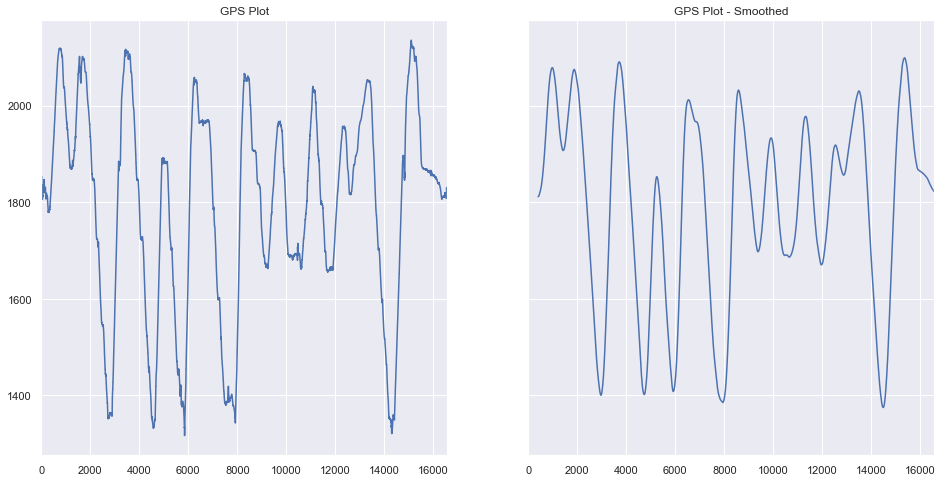

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
data.GPS_Alt.plot(ax=ax1,title='GPS Plot')
data.gps_alt_roll.plot(ax=ax2,title='GPS Plot - Smoothed')


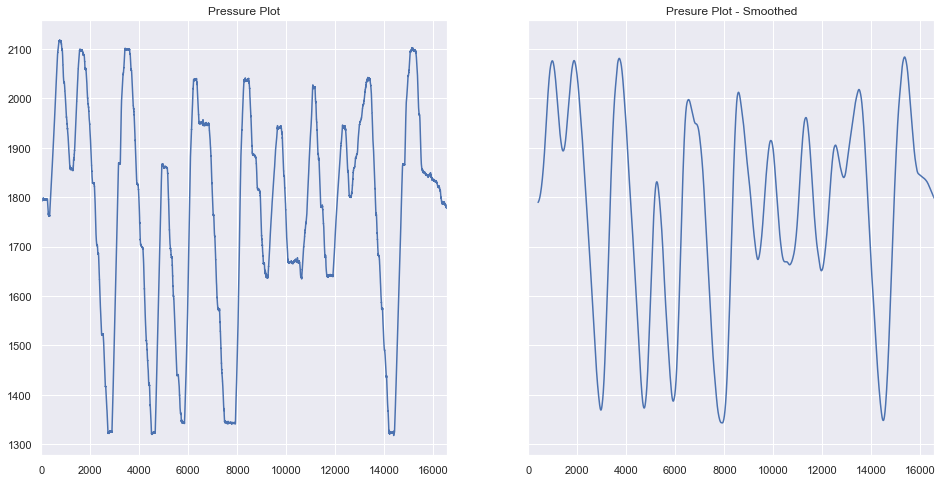

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
data.Pres_Alt.plot(ax=ax1,title='Pressure Plot')
data.pres_alt_roll.plot(ax=ax2,title='Presure Plot - Smoothed')

In [11]:
data['gps_alt_roll_delta'] = data.gps_alt_roll[:-1] - data.gps_alt_roll[1:].values
data['gps_alt_raw_delta'] = data.GPS_Alt[:-1] - data.GPS_Alt[1:].values
data['pres_alt_roll_delta'] = data.pres_alt_roll[:-1] - data.pres_alt_roll[1:].values
data['pres_alt_raw_delta'] = data.Pres_Alt[:-1] - data.Pres_Alt[1:].values

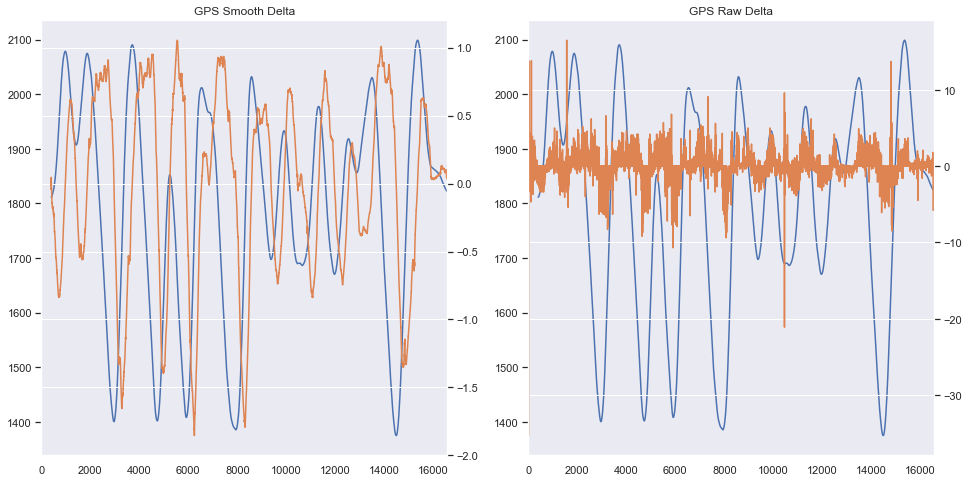

In [12]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta')
data.gps_alt_roll_delta.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta')
data.gps_alt_raw_delta.plot(ax=ax[1],secondary_y=True)

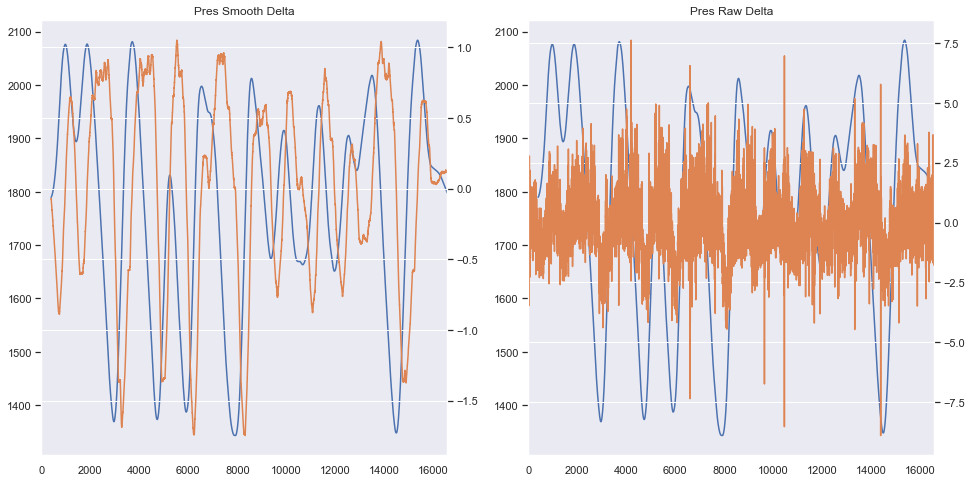

In [13]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.pres_alt_roll.plot(ax=ax[0],title='Pres Smooth Delta')
data.pres_alt_roll_delta.plot(ax=ax[0],secondary_y=True)
data.pres_alt_roll.plot(ax=ax[1],title='Pres Raw Delta')
data.pres_alt_raw_delta.plot(ax=ax[1],secondary_y=True)

In [14]:
#data['gps_alt_roll_delta_roll_delta'] = data.gps_alt_roll_delta_roll[:-1] - data.gps_alt_roll_delta_roll[1:].values
#data['gps_alt_roll_delta_roll_delta_roll'] =data.gps_alt_roll_delta_roll_delta.rolling(240).mean()

#data['gps_alt_raw_delta_roll_delta'] = data.gps_alt_raw_delta_roll[:-1] - data.gps_alt_raw_delta_roll[1:].values
#data['gps_alt_raw_delta_roll_delta_roll'] =data.gps_alt_raw_delta_roll_delta.rolling(240).mean()

data['gps_alt_raw_delta_roll'] =data.gps_alt_raw_delta.rolling(180).mean()
data['gps_alt_roll_delta_roll'] =data.gps_alt_roll_delta.rolling(180).mean()

data['pres_alt_raw_delta_roll'] =data.pres_alt_raw_delta.rolling(180).mean()
data['pres_alt_roll_delta_roll'] =data.pres_alt_roll_delta.rolling(180).mean()

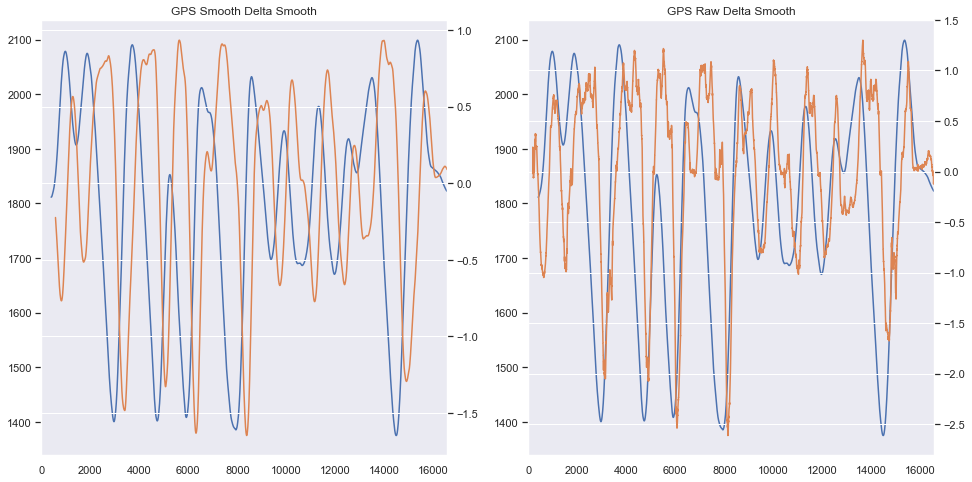

In [15]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta Smooth')
data.gps_alt_roll_delta_roll.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta Smooth')
data.gps_alt_raw_delta_roll.plot(ax=ax[1],secondary_y=True)

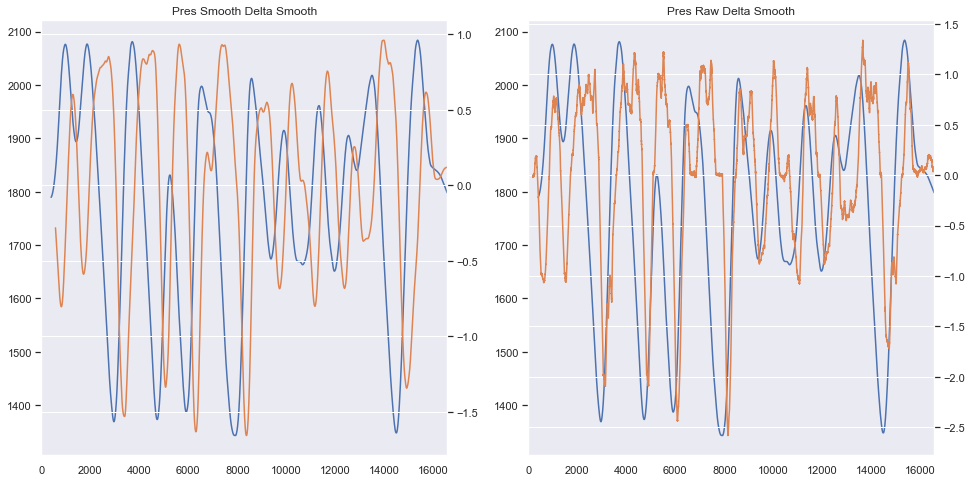

In [16]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.pres_alt_roll.plot(ax=ax[0],title='Pres Smooth Delta Smooth')
data.pres_alt_roll_delta_roll.plot(ax=ax[0],secondary_y=True)
data.pres_alt_roll.plot(ax=ax[1],title='Pres Raw Delta Smooth')
data.pres_alt_raw_delta_roll.plot(ax=ax[1],secondary_y=True)

In [17]:
signs = np.sign(data.gps_alt_raw_delta_roll.fillna(0))
signchange = ((np.roll(signs, 1) - signs) != 0).astype(int)

In [18]:
sign_changes_idx = signchange.index[signchange == 1].tolist()

In [19]:
routes_list=[]
for i in range(len(sign_changes_idx)-1):
    #print(sign_changes_idx[i],sign_changes_idx[i+1]-1, signs[sign_changes_idx[i]])
    start = sign_changes_idx[i]
    end = sign_changes_idx[i+1]-1
    sign = signs[sign_changes_idx[i]]
    max_val = np.max(data.loc[start:end,('gps_alt_raw_delta_roll')])
    routes_list.append((start,end,sign,max_val ))
    
routes = pd.DataFrame(routes_list,columns=['start_idx','end_idx','sign','peak'])
routes.head()

,start_idx,end_idx,sign,peak
0,179,180,-1.0,-0.012222
1,181,202,1.0,0.241667
2,203,230,-1.0,-0.002778
3,231,231,0.0,0.000000
4,232,235,-1.0,-0.001111


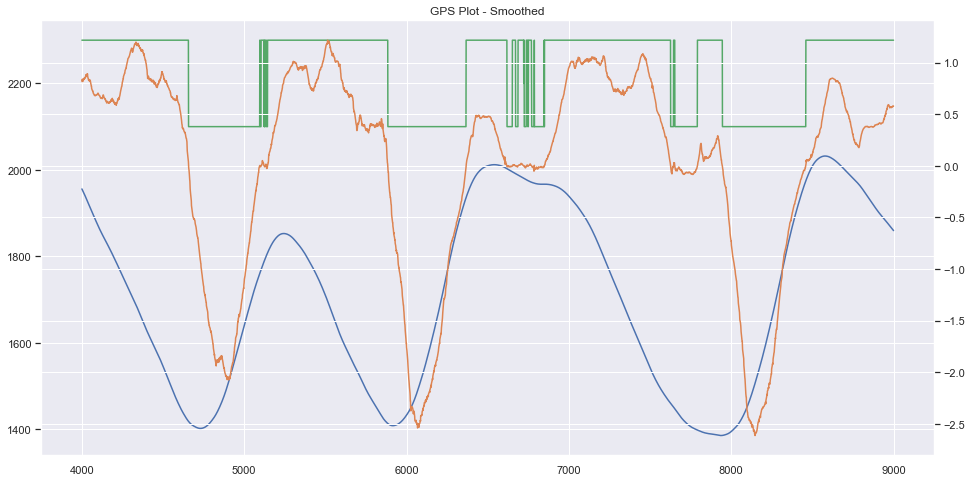

In [20]:
small_data =data.loc[4000:9000]
small_signs = signs.loc[4000:9000] *100 +2200
fig, ax= plt.subplots(1, 1, figsize=(16,8))
small_data.gps_alt_roll.plot(ax=ax,title='GPS Plot - Smoothed')
small_data.gps_alt_raw_delta_roll.plot(ax=ax,secondary_y=True)
small_signs.plot(ax=ax)

In [20]:
peak_filter = 0.5
runs = routes[(routes.sign== 1) & (routes.peak >= peak_filter)].copy()
runs.reset_index(inplace=True)
num_runs = runs.shape[0]
num_runs

11

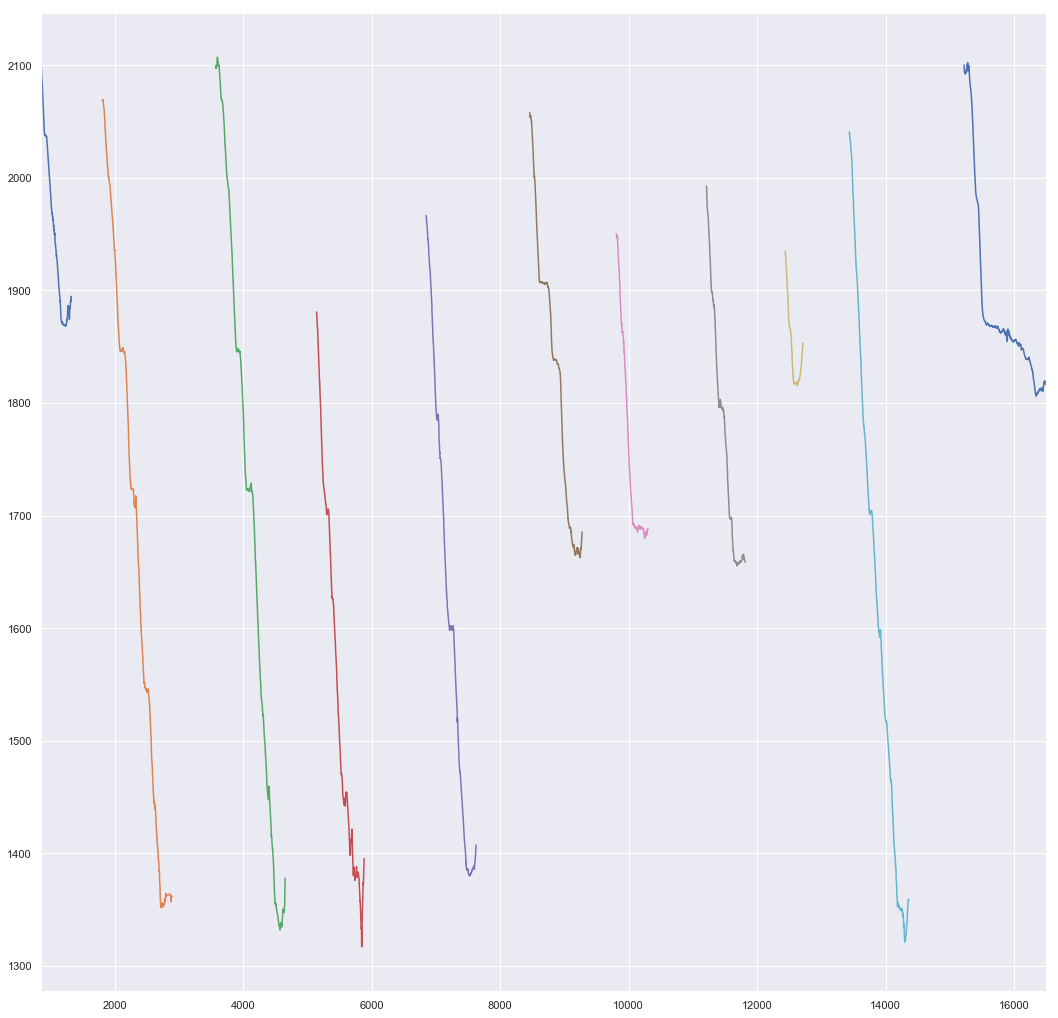

In [21]:
fig, axes= plt.subplots(1,1, figsize=(18,18))
#axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes)

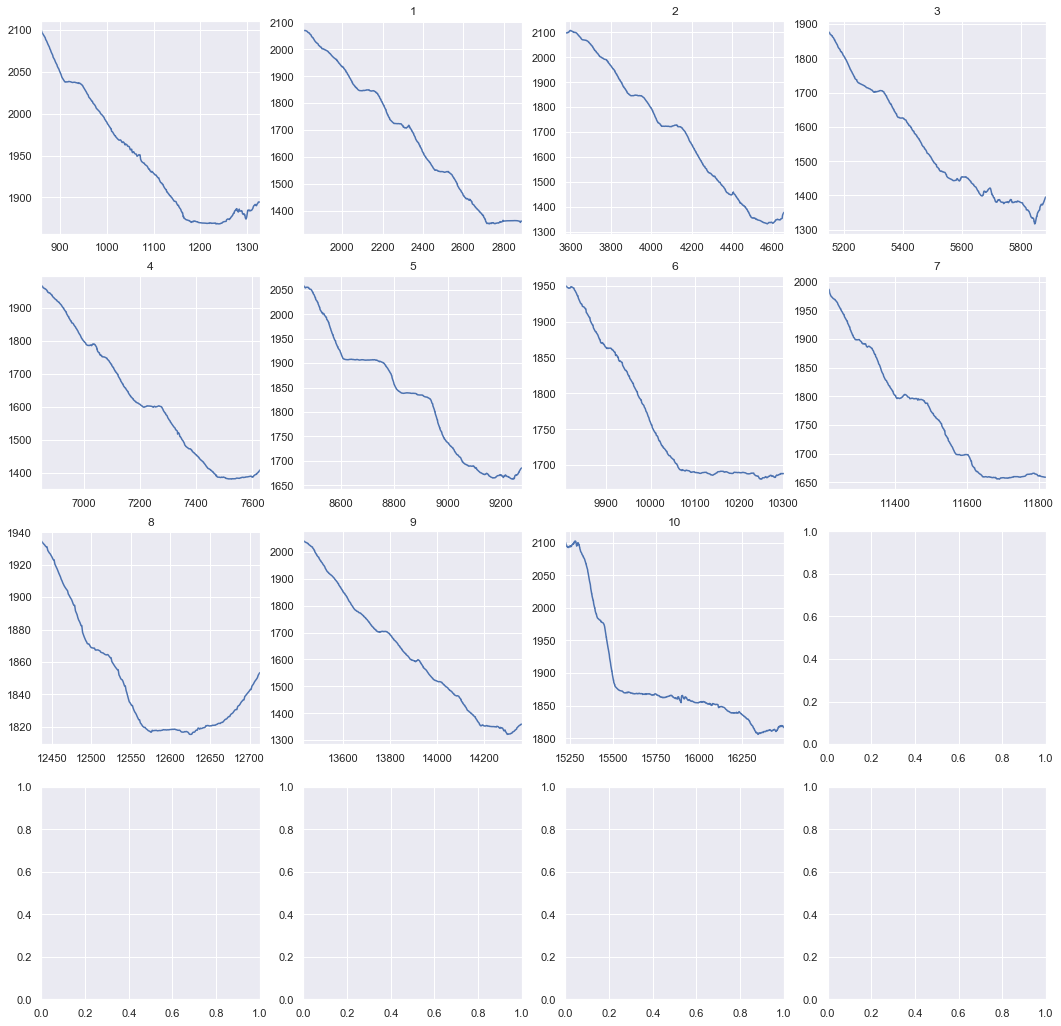

In [22]:
fig, axes= plt.subplots(4, 4, figsize=(18,18))
axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes[i], title=i)

In [23]:
data.columns.T

Index(['Date', 'Time', 'Lat', 'Lon', 'GPS_Alt', 'Pressure', 'Pres_Alt', 'Temp',
       'Batt', 'Lat_Rad', 'Lon_Rad', 'Lat_Delta', 'Lon_Delta', 'Lat_Rad_Delta',
       'Lon_Rad_Delta', 'GPS_Alt_Delta', 'Pres_Alt_Delta', 'datetime',
       'time_delta', 'distance', 'distance_cum', 'speed', 'gradient',
       'pres_gradient', 'grad_roll', 'grad_colour', 'gps_alt_roll',
       'pres_alt_roll', 'gps_alt_raw_delta', 'pres_alt_raw_delta',
       'gps_alt_raw_delta_roll', 'pres_alt_raw_delta_roll',
       'gps_alt_roll_delta', 'pres_alt_roll_delta', 'gps_alt_roll_delta_roll',
       'pres_alt_roll_delta_roll'],
      dtype='object')

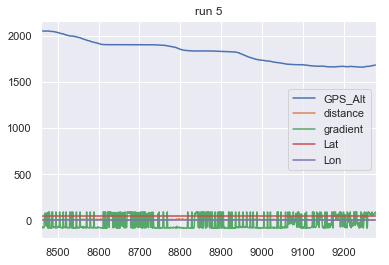

In [64]:
start  =np.int(runs.loc[5].start_idx)
end =  np.int(runs.loc[5].end_idx)
#print(start, end)
run_5 = data.loc[start:end,('GPS_Alt','distance','gradient','Lat','Lon')]
    
    
run_5.plot(title='run 5')

In [65]:
run_5.describe()

,GPS_Alt,distance,gradient,Lat,Lon
count,819.000000,819.000000,819.000000,819.000000,819.000000
mean,1824.390232,3.687859,-27.783146,45.153193,6.097263
std,119.697086,3.137065,73.561649,0.007599,0.002228
min,1662.600000,0.078428,-89.229217,45.139343,6.093254
25%,1691.300000,0.905090,-83.294721,45.147259,6.095653
50%,1838.100000,3.068758,-76.195375,45.153099,6.096662
75%,1906.800000,5.597928,67.511076,45.161701,6.099376
max,2058.200000,17.307614,89.999927,45.162838,6.101047


In [66]:
total_height = run_5.GPS_Alt.max() - run_5.GPS_Alt.min()
total_height

395.5999999999999

In [67]:
total_distance = run_5.distance.sum()
total_distance

3020.3568471546155

In [68]:
total_distance / total_height

7.634875751149181

In [69]:
run_5['distance_cum'] =run_5.distance.cumsum()


In [70]:
from skitracker_utils import calc_grad_roll_colour

In [71]:
run_5['grad_roll'] =run_5.gradient.rolling(20).mean()

In [72]:
run_5['grad_colour'] = run_5.apply(calc_grad_roll_colour, axis=1,grad_field = 'grad_roll')

In [73]:
cmap = {1:'g',2:'b',0:'r'}
run_5['grad_colour_c'] = run_5.apply(lambda x:cmap[x.grad_colour] ,axis=1)

In [74]:
run_5.head()

,GPS_Alt,distance,gradient,Lat,Lon,distance_cum,grad_roll,grad_colour,grad_colour_c
8460,2058.2,1.969930,-84.202825,45.139343,6.093254,1.969930,NaN,0,r
8461,2057.9,2.859600,-84.011021,45.139351,6.093276,4.829530,NaN,0,r
8462,2057.6,6.404696,-87.318190,45.139366,6.093306,11.234226,NaN,0,r
8463,2056.7,2.926017,-72.902868,45.139412,6.093355,14.160243,NaN,0,r
8464,2055.6,3.144994,-70.722091,45.139435,6.093373,17.305237,NaN,0,r


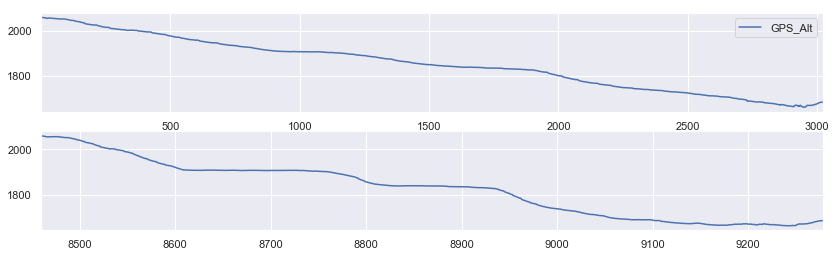

In [75]:
fig, axes= plt.subplots(2,1, figsize=(14,4))
# run_5.GPS_Alt.plot(ax=axes)
run_5.plot.line(x='distance_cum',y='GPS_Alt',ax=axes[0])
run_5.GPS_Alt.plot(ax=axes[1])
#run_5.grad_roll.plot(ax=axes,secondary_y=True,c=run_5['grad_colour_c'] )
#plt.plot(x=run_5.index,y=run_5.GPS_Alt,c=run_5.grad_colour_c)
#plt.plot(x=run_5.distance_cum, y=run_5.GPS_Alt)

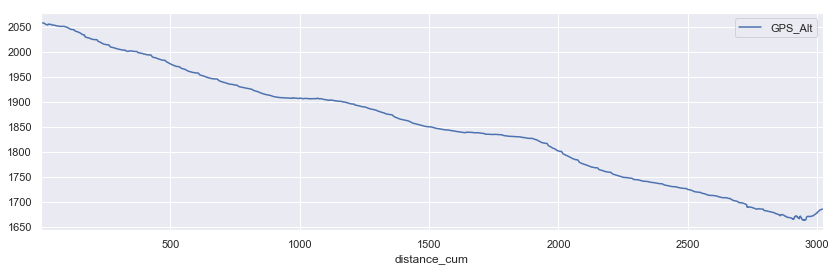

In [76]:
fig, axes= plt.subplots(1,1, figsize=(14,4))
# run_5.GPS_Alt.plot(ax=axes)
run_5.plot.line(x='distance_cum',y='GPS_Alt',ax=axes)#run_5.grad_colour_c)
#run_5.GPS_Alt.plot(ax=axes[1])

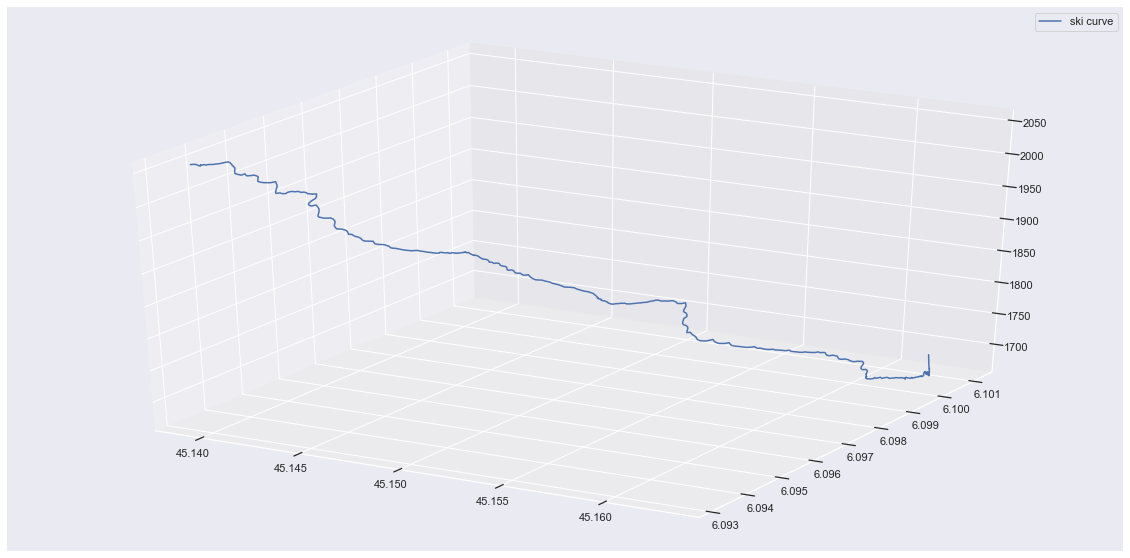

In [77]:
fig=plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
x = run_5.Lat
y = run_5.Lon
z= run_5.GPS_Alt
ax.plot(x, y, z, label='ski curve')
ax.legend()

plt.show()